In [1]:
import sys
sys.path.insert(0, '../scripts')
from map_traffic_lights_data import *
from l5kit_modified.l5kit_modified import FramesDataset
import matplotlib.pyplot as plt
import numpy as np

from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from IPython.display import display, clear_output
import PIL
import time

import cv2
from tqdm.auto import tqdm
import bisect
from torch.utils.data import DataLoader

import os
import imutils
import pickle
from collections import deque
from functools import partial
%matplotlib inline

In [2]:
os.environ["L5KIT_DATA_FOLDER"] = "../input/"
# get config
cfg = load_config_data("./visualisation_config.yaml")
cfg["raster_params"]["map_type"] = "py_semantic"
cfg['raster_params']['raster_size'] = [350, 350] #[532, 532]
# cfg['raster_params']['pixel_size'] = [1, 1]
# cfg['raster_params']['ego_center'] = [0.4, 0.5]

dm = LocalDataManager()
dataset_path = dm.require('scenes/validate_filtered_min_frame_history_4_min_frame_future_1_with_mask_idx.zarr')#validate_filtered_min_frame_history_4_min_frame_future_1.zarr')
frame_dataset = FramesDataset(dataset_path, agents_from_standard_mask_only=True, return_indices=True)

dataset_path_masked = dm.require('scenes/validate_filtered_min_frame_history_10_min_frame_future_1.zarr')#validate_filtered_min_frame_history_4_min_frame_future_1.zarr')
zarr_dataset_masked = ChunkedDataset(dataset_path_masked)
zarr_dataset_masked.open()

rast = build_rasterizer(cfg, dm)
dataset_filtered = EgoDataset(cfg, zarr_dataset_masked, rast)

In [3]:
def get_agent_lanes_info(frame_sample, add_centroid=False):
    timestamp = datetime.fromtimestamp(frame_sample['timestamp']/10**9).astimezone(timezone('US/Pacific'))
    scene_idx = frame_sample['scene_index']
    track_speed_yaw_lane_point_list = []
    agents_with_wheels = [(agent, ALL_WHEELS_CLASS if np.nonzero(agent[-1])[0][0] == CAR_CLASS else BIKE_CLASS) for agent in frame_sample['agents'] if np.nonzero(agent[-1])[0][0] in [CAR_CLASS, BIKE_CLASS]]
    for agent, agent_class in agents_with_wheels:
        agent_track_id = agent[-2]
        agent_speed = np.hypot(*agent[-3])
        agent_centroid = agent[0]
        agent_yaw = agent[2]
        find_closest_result = find_closest_lane(agent_centroid, agent_yaw, agent_class,
                                                                    return_point_i=True, 
                                                                    return_blocked_tl_signals=False, 
                                                                    intersections_only=False)
        matched_map_segments = match_point_2_map_segment(*agent_centroid)
        if len(matched_map_segments):
            map_segment_group = matched_map_segments[0]
        else:
            map_segment_group = NUM_MAP_SEGMENTS
        if find_closest_result is not None:
            lane_id, lane_point_i = find_closest_result
            if add_centroid:
                track_speed_yaw_lane_point_list.append((agent_centroid, agent_track_id, scene_idx, timestamp, map_segment_group, agent_speed, agent_yaw, lane_id, lane_point_i))
            else:
                track_speed_yaw_lane_point_list.append((agent_track_id, scene_idx, timestamp, map_segment_group, agent_speed, agent_yaw, lane_id, lane_point_i))
            
    
    return track_speed_yaw_lane_point_list

In [4]:
def agent_lanes_collate_fn(frames_batch, 
                           timestamp_min=datetime(1970, 11, 20).astimezone(timezone('US/Pacific')), 
                           timestamp_max=datetime(2021, 11, 20).astimezone(timezone('US/Pacific'))):
    batch_result = []
    for frame in frames_batch:
        timestamp = datetime.fromtimestamp(frame['timestamp'] / 10 ** 9).astimezone(timezone('US/Pacific'))
        if timestamp_min < timestamp <= timestamp_max:
            agent_lanes_info = get_agent_lanes_info(frame)
            batch_result.extend(agent_lanes_info)
    return np.array(batch_result)

In [5]:
cycled_colors = plt.get_cmap('tab20b')(np.linspace(0, 1, 20))
cycled_colors_2 = plt.get_cmap('Set2')(np.linspace(0, 1, 8))

def plot_agent(ax, agent_coord, agent_color, speed, yaw, lane_id, lane_color, point_i, speed_min=-2, speed_max=12.295, track_id=''): 
    lane_center_line = get_lane_center_line(lane_id)
    lane_left_board, lane_right_board = get_lane_boarders(lane_id)    
    
    speed = np.clip(speed, speed_min, speed_max)
    color_speed = plt.get_cmap('Oranges')((speed - speed_min)/(speed_max - speed_min))
    
    ax.scatter(lane_center_line[point_i, 0], lane_center_line[point_i, 1], s=9, color=lane_color) 
    ax.scatter(lane_center_line[:point_i, 0], lane_center_line[:point_i, 1], s=3, color='grey')  
    if point_i < get_lane_len(lane_id) - 1:
        ax.scatter(lane_center_line[point_i+1:, 0], lane_center_line[point_i+1:, 1], s=3, color='grey') 

    
    ax.scatter(agent_coord[0], agent_coord[1], s=20, color=agent_color) 
    ax.arrow(agent_coord[0], agent_coord[1], 7*np.cos(yaw), 7*np.sin(yaw), color=agent_color)                        
    ax.text(agent_coord[0], agent_coord[1] + 0.7, 
            f'{speed:.0f} ({track_id})', color=color_speed, 
            fontsize=14)

    
    
def store_output(im, output, start_scene, end_scene, show):
    if output is None:
        start_scene = f'{"".join(["0" for _ in range(3 - len(str(start_scene)))])}{start_scene}'
        end_scene = f'{"".join(["0" for _ in range(3 - len(str(end_scene)))])}{end_scene}'
        output = cv2.VideoWriter(f'../outputs/vis_lane_sec_{start_scene}_{end_scene}.avi',
                                 cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 10, (im.shape[1], im.shape[0]))
    output.write(cv2.cvtColor(im, cv2.COLOR_RGB2BGR))
    if show:
        clear_output(wait=True)
        display(PIL.Image.fromarray(im))
        time.sleep(0.01)
    return output
        
def run(frame_dataset, dataset_filtered, scene_idx_bounds, output=None, show=False, scenes_per_video=10, vis=True
       ):
    scenes_per_video = min(scenes_per_video, scene_idx_bounds[1] - scene_idx_bounds[0])
    lane_id_2_count = defaultdict(int)
    all_masked_agents, matched_masked_agents = 0, 0
    for start_scene in tqdm(range(*scene_idx_bounds, scenes_per_video), desc='Scenes...'):
        end_scene = start_scene + scenes_per_video
        for scene_idx in range(start_scene, end_scene): #, desc=f'scenes {start_scene}-{end_scene}..':
            indexes = frame_dataset.get_scene_indices(scene_idx)
            track_ids = set()
            agent_id_2_color_idx = dict()
            lane_completion_2_color_idx = dict()

            for idx in tqdm(indexes, desc='sc'):

                agents_info = get_agent_lanes_info(frame_dataset[idx], add_centroid=True)
#                 print(agents_info)
#                 print('masked agents:', zarr_dataset_masked.agents[slice(*zarr_dataset_masked.frames[idx][1])])
                all_masked_agents += len(range(*zarr_dataset_masked.frames[idx][1]))
                matched_masked_agents += len(agents_info)
                for _, agent_track_id, _, _, _, _, _, lane_id, _ in agents_info:
                    lane_id_2_count[lane_id] += 1
                    track_ids.add(agent_track_id)
                                
                if len(agents_info) and vis:
                    
                    data_filtered = dataset_filtered[idx]
                    im_filtered = data_filtered["image"].transpose(1, 2, 0)
                    im_filtered = dataset_filtered.rasterizer.to_rgb(im_filtered)[::-1, :, :]

                    fig = plt.figure(figsize=(5, 5))
                    ax = fig.add_subplot(111)
                    plt.axis('off')
                    for agent_centroid, agent_track_id, _, _, _, agent_speed, agent_yaw, lane_id, lane_point_i in agents_info:
                        if agent_track_id not in agent_id_2_color_idx:
                            agent_id_2_color_idx[agent_track_id] = len(agent_id_2_color_idx)
                            
#                         lane_completion_segment = bisect.bisect(completion_cuts, lane_completion)
                        if (lane_id, lane_point_i) not in lane_completion_2_color_idx:
                            lane_completion_2_color_idx[(lane_id, lane_point_i)] = len(lane_completion_2_color_idx)
                        agent_color = cycled_colors_2[agent_id_2_color_idx[agent_track_id]%len(cycled_colors_2)]
                        lane_color = cycled_colors[lane_completion_2_color_idx[(lane_id, lane_point_i)]%len(cycled_colors)]
                        plot_agent(ax, agent_centroid, agent_color, agent_speed, agent_yaw, lane_id, lane_color, lane_point_i, track_id=agent_track_id)
                    ego_centroid = frame_dataset[idx]['ego_centroid']
                    ego_yaw = frame_dataset[idx]['ego_yaw']
                    ax.set_xlim((ego_centroid[0] - 30, ego_centroid[0] + 30))
                    ax.set_ylim((ego_centroid[1] - 30, ego_centroid[1] + 30))

                    plt.title(f'scene: {scene_idx}, frame: {idx}')
                    fig.canvas.draw()
                    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='').reshape(fig.canvas.get_width_height() + (3,))
                    plt.close()

                    im_plt = cv2.resize(data, (im_filtered.shape[1], im_filtered.shape[0]))
                    im = np.concatenate((imutils.rotate(im_filtered, 180*ego_yaw/np.pi), np.zeros((im_filtered.shape[0], 20, im_filtered.shape[2]), dtype='uint8'), im_plt), axis=1)
                    output = store_output(im, output, start_scene, end_scene, show)
            print('track ids from scene', track_ids)
        if output is not None:
            output.release()
            output = None
        print('closed...')
#     return all_masked_agents, matched_masked_agents
    return lane_id_2_count

In [6]:
_ = run(frame_dataset, dataset_filtered, [5, 7], show=False, vis=False)


track ids from scene {1, 2, 4, 5, 7, 8, 263, 10, 11, 138, 651, 647, 15, 405, 25, 26, 27, 28, 30, 31, 33, 299, 302, 562, 439, 696, 313, 58, 569, 316, 62, 318, 192, 703, 322, 584, 206, 466, 600, 475, 94, 223, 350, 355, 108, 622, 239, 240, 501, 123}



track ids from scene {1, 2, 3, 4, 5, 6, 257, 390, 9, 10, 11, 12, 140, 266, 17, 531, 404, 25, 27, 28, 29, 285, 539, 170, 431, 434, 180, 182, 310, 440, 63, 195, 72, 457, 83, 339, 96, 227, 488, 105, 365, 246, 511}
closed...



In [7]:
timestamp_min = datetime(2016, 2, 2).astimezone(timezone('US/Pacific'))
timestamp_max = datetime(2021, 2, 2).astimezone(timezone('US/Pacific'))

dataloader_frames = DataLoader(frame_dataset, shuffle=False, batch_size=32,
                               num_workers=12,
                               collate_fn=partial(agent_lanes_collate_fn, timestamp_min=timestamp_min, timestamp_max=timestamp_max))

In [10]:
def get_agent_lanes_df(dataloader_frames):
    count = 0
    agent_track_id_list, scene_idx_list, timestamp_list, map_segment_group_list, agent_speed_list, agent_yaw_list, lane_id_list, lane_point_i_list = [
        [] for _ in range(8)]
    for batch in tqdm(dataloader_frames, desc='Agents info events...'):
        count += 1
        if count >= 200: break
        for record in batch:
            agent_track_id, scene_idx, timestamp, map_segment_group, agent_speed, agent_yaw, lane_id, lane_point_i = record
            agent_track_id_list.append(agent_track_id)
            scene_idx_list.append(scene_idx)
            timestamp_list.append(timestamp)
            map_segment_group_list.append(map_segment_group)
            agent_speed_list.append(agent_speed)
            agent_yaw_list.append(agent_yaw)
            lane_id_list.append(lane_id)
            lane_point_i_list.append(lane_point_i)

    agent_lanes_df = pd.DataFrame({'agent_track_id': agent_track_id_list,
                                   'scene_idx': scene_idx_list,
                                 'timestamp': timestamp_list,
                                   'map_segment_group': map_segment_group_list,
                                 'agent_speed': agent_speed_list,
                                 'agent_yaw': agent_yaw_list,
                                 'lane_id': lane_id_list,
                                 'lane_point_i': lane_point_i_list})
    agent_lanes_df.sort_values(by=['agent_track_id', 'scene_idx', 'timestamp'], inplace=True)
    return agent_lanes_df

In [11]:
agent_lanes_df = get_agent_lanes_df(dataloader_frames)

In [12]:
agent_lanes_df.shape

(33195, 8)

In [13]:
pd.set_option('display.max_rows', 200)
agent_lanes_df.head(100)

,agent_track_id,scene_idx,timestamp,map_segment_group,agent_speed,agent_yaw,lane_id,lane_point_i
0,1,0,2019-12-13 08:36:12.102466-08:00,8,0.873264,2.061018,vC8o,3
1,1,0,2019-12-13 08:36:12.202533-08:00,8,0.896005,2.057261,vC8o,3
2,1,0,2019-12-13 08:36:12.302542-08:00,8,0.874999,2.041698,vC8o,3
3,1,0,2019-12-13 08:36:12.402505-08:00,8,0.864475,2.035878,vC8o,3
4,1,0,2019-12-13 08:36:12.502441-08:00,8,0.880178,2.036298,vC8o,3
5,1,0,2019-12-13 08:36:12.602407-08:00,8,0.894186,2.035804,vC8o,3
6,1,0,2019-12-13 08:36:12.702427-08:00,8,0.891254,2.033586,vC8o,3
7,1,0,2019-12-13 08:36:12.802507-08:00,8,0.876485,2.033772,vC8o,3
8,1,0,2019-12-13 08:36:12.902647-08:00,8,0.877935,2.035060,vC8o,3
9,1,0,2019-12-13 08:36:13.002803-08:00,8,0.879825,2.038865,vC8o,3


In [8]:
# lane_id_2_count_val = run(frame_dataset, dataset_filtered, 
#                       [0, len(frame_dataset.zarr_root['scenes'])], show=False, vis=False)

In [9]:
# with open('../outputs/lane_id_2_count_val.pkl', 'wb') as f:
#     pickle.dump(lane_id_2_count_val, f)
with open('../outputs/lane_id_2_count_val.pkl', 'rb') as f:
    lane_id_2_count_val = pickle.load(f)

In [10]:
min(lane_id_2_count_val.values()), max(lane_id_2_count_val.values())

(1, 303810)

Text(0.5, 1.0, 'Lanes visited in the VAL set')

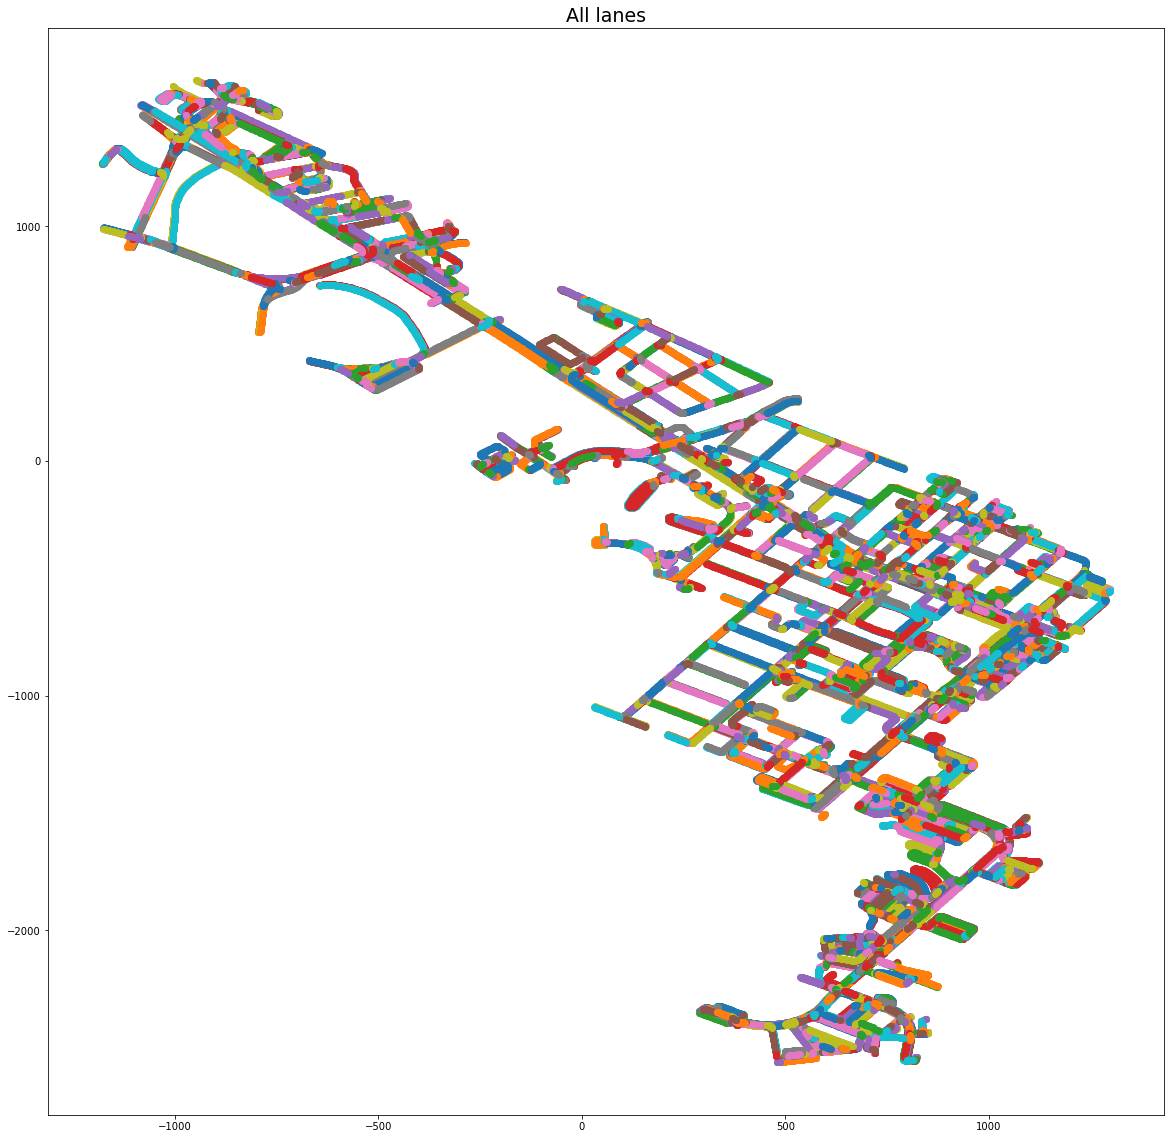

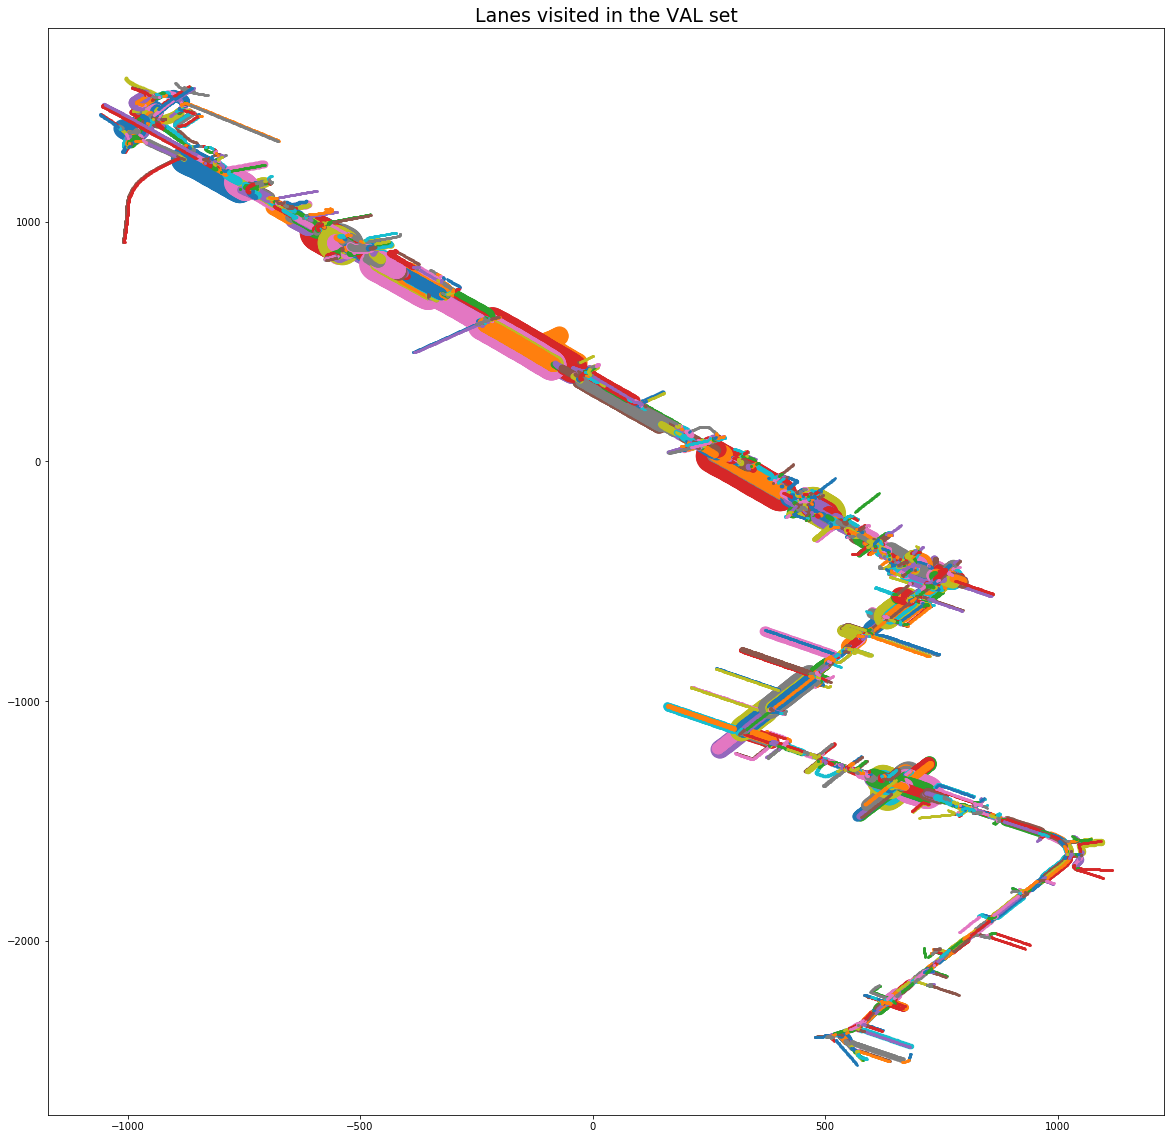

In [11]:
plt.figure(figsize=(20, 20))
for lane_id in tqdm(lane_id_2_idx):
    lane_center_line = get_lane_center_line(lane_id)
    plt.scatter(lane_center_line[:, 0], lane_center_line[:, 1])
plt.title('All lanes', fontsize=19)

plt.figure(figsize=(20, 20))
max_point_size = 1200
max_lane_freq = max(lane_id_2_count_val.values())
for lane_id, lane_freq in tqdm(lane_id_2_count_val.items()):
    lane_center_line = get_lane_center_line(lane_id)
    point_size = max(3, lane_freq*max_point_size/max_lane_freq)
    plt.scatter(lane_center_line[:, 0], lane_center_line[:, 1], s=point_size)
plt.title('Lanes visited in the VAL set', fontsize=19)

Text(0.5, 1.0, 'Rotated lanes visited in the VAL set')

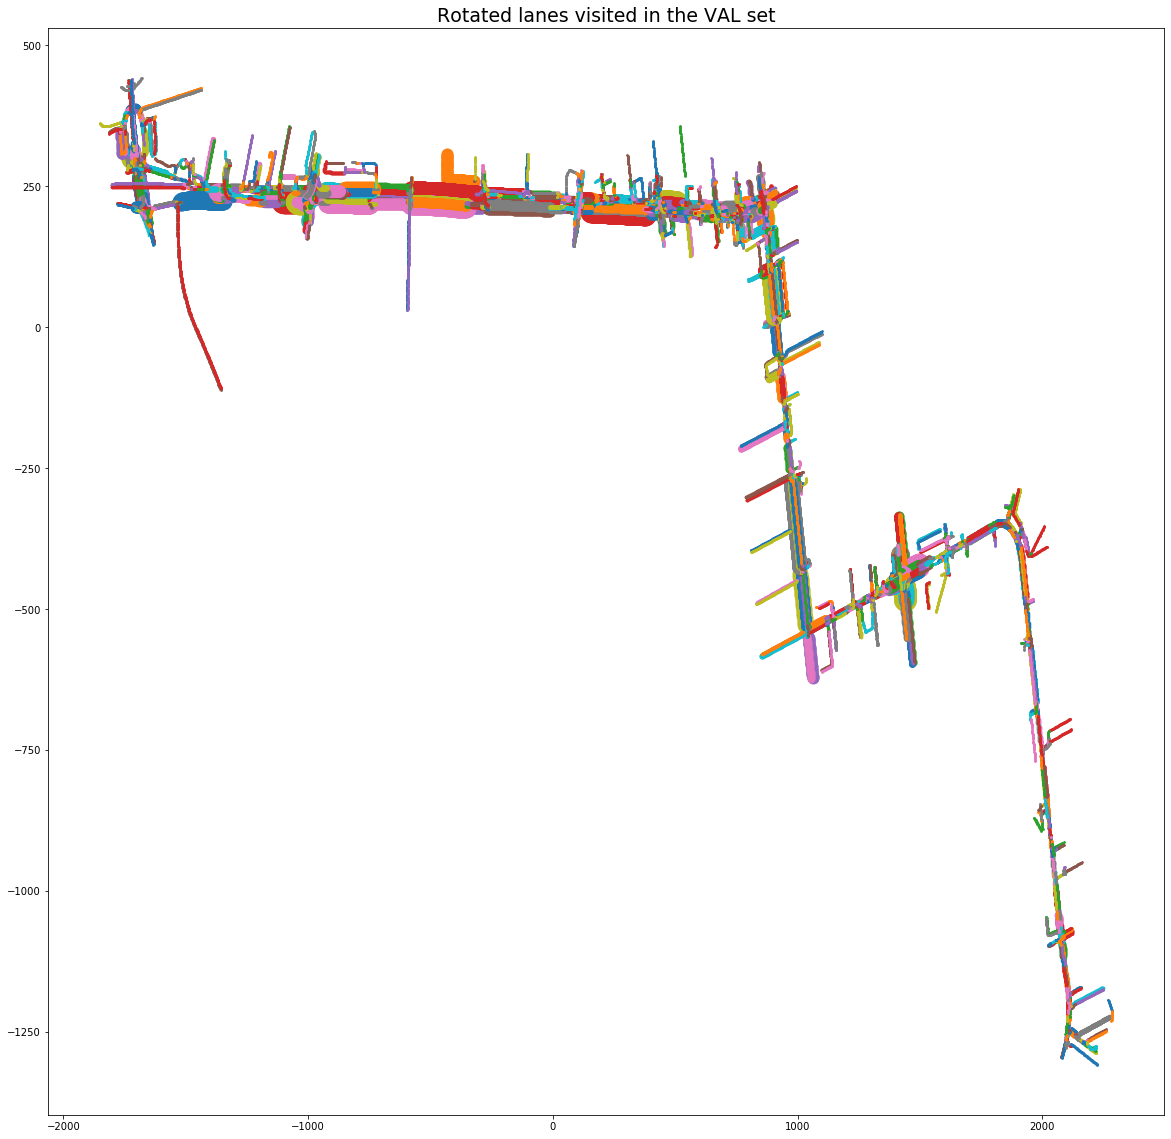

In [12]:
def rotate_point(x, y, angle_rad=0.26*np.pi, back=False):
    if back:
        angle_rad *= -1
    cos, sin = np.cos(angle_rad), np.sin(angle_rad)
    return x*cos - y*sin, x*sin + y*cos


plt.figure(figsize=(20, 20))
max_point_size = 500
max_lane_freq = max(lane_id_2_count_val.values())
for lane_id, lane_freq in tqdm(lane_id_2_count_val.items()):
    lane_center_line = get_lane_center_line(lane_id).copy()
    for point_i in range(len(lane_center_line)):
        lane_center_line[point_i] = rotate_point(*lane_center_line[point_i])
    point_size = max(3, lane_freq*max_point_size/max_lane_freq)
    plt.scatter(lane_center_line[:, 0], lane_center_line[:, 1], s=point_size)
plt.title('Rotated lanes visited in the VAL set', fontsize=19)

Text(0.5, 1.0, 'Rotated lanes visited in the VAL set')

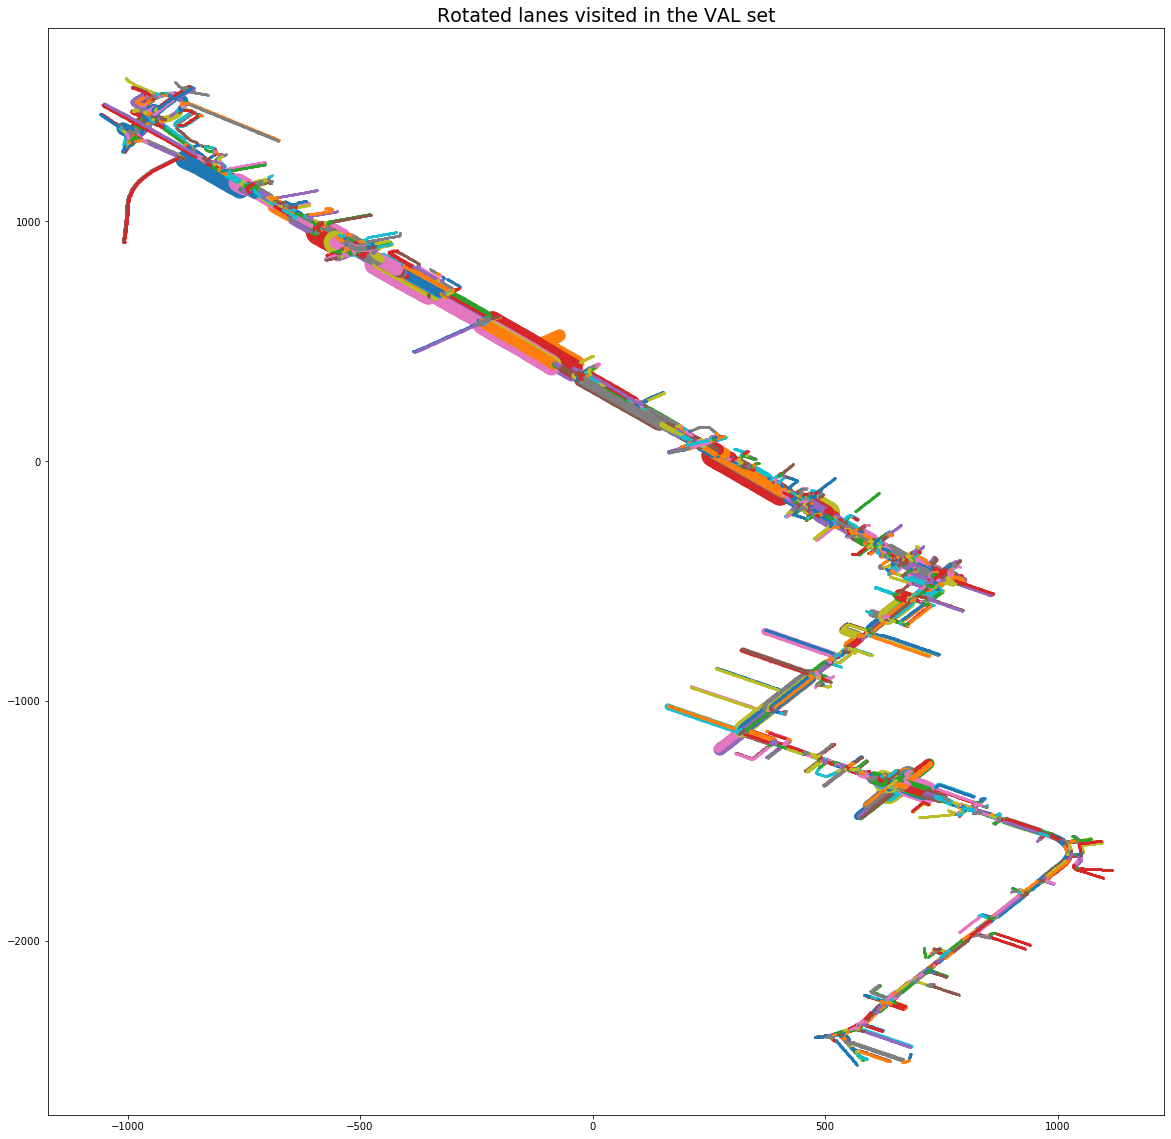

In [13]:
plt.figure(figsize=(20, 20))
max_point_size = 500
max_lane_freq = max(lane_id_2_count_val.values())
for lane_id, lane_freq in tqdm(lane_id_2_count_val.items()):
    lane_center_line = get_lane_center_line(lane_id).copy()
    for point_i in range(len(lane_center_line)):
        lane_center_line[point_i] = rotate_point(*rotate_point(*lane_center_line[point_i]), back=True)
    point_size = max(3, lane_freq*max_point_size/max_lane_freq)
    plt.scatter(lane_center_line[:, 0], lane_center_line[:, 1], s=point_size)
plt.title('Rotated lanes visited in the VAL set', fontsize=19)

In [14]:
len(lane_id_2_count_val)

2530

In [15]:
lane_ids = []
coordinates = []

def add_lane(lane_id):
    lane_ids.append(lane_id)
    center_line = get_lane_center_line(lane_id)
    mean_x, mean_y = center_line[:, 0].mean(), center_line[:, 1].mean()
    coordinates.append([mean_x, mean_y])

for lane_id in tqdm(lane_id_2_count_val):
    add_lane(lane_id)
    for lane_neighb_id in get_lane_neighbours_all(lane_id) + get_lane_neighbours_based_on_dist(lane_id):
        if lane_neighb_id not in lane_id_2_count_val:
            add_lane(lane_id)
# 
coords_np = np.array(coordinates)
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=13, random_state=0)
kmeans.fit(coordinates)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [16]:
lanes_clusters = pd.DataFrame({'cluster':kmeans.labels_, 'lane_id': lane_ids})
cluster_2_lanes = lanes_clusters.groupby('cluster')['lane_id'].agg(list)

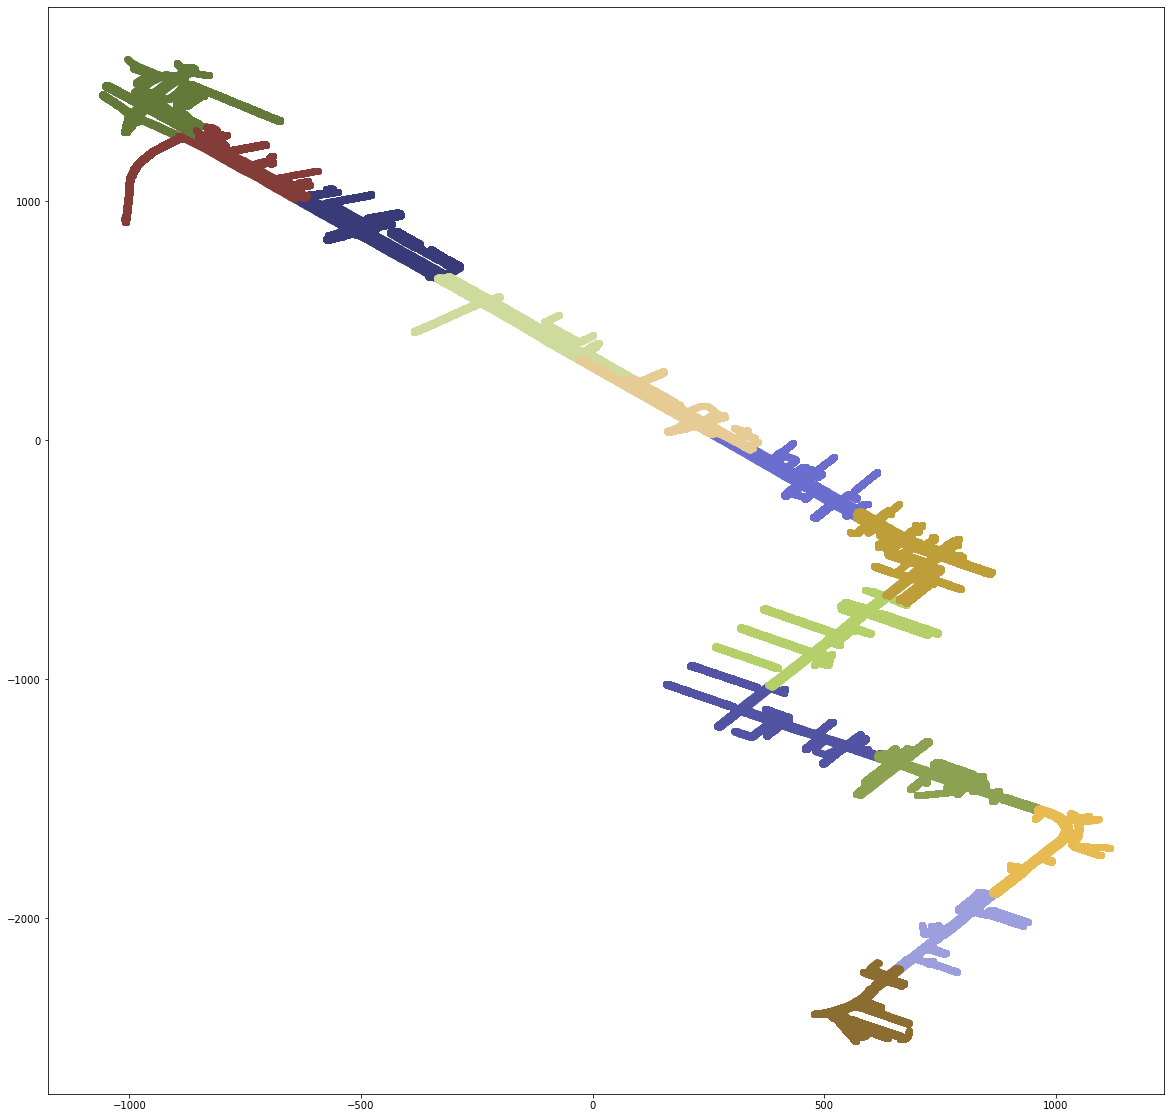

In [17]:
plt.figure(figsize=(20, 20))
lane_2_clusters = dict()
for cluster, lanes in cluster_2_lanes.iteritems():
    
    for lane_id in lanes:
        lane_2_clusters[lane_id] = cluster
        center_line = get_lane_center_line(lane_id)
        plt.scatter(center_line[:,0], center_line[:,1], color=cycled_colors[cluster%len(cycled_colors)])

In [18]:
intersection_sets = []
covered_lanes = set()
for lane_id in lane_id_2_count_val:
    if lane_id in lane_2_master_intersection_related_lanes and lane_id not in covered_lanes:
        intersection_set = lane_2_master_intersection_related_lanes[lane_id].copy()
        intersection_set.add(lane_id)
        covered_lanes.update(intersection_set)
        intersection_sets.append(intersection_set)       
    if len(intersection_sets) == 10:
        break
        
for intersection_set in intersection_sets:
    intersection_clusters = defaultdict(int)
    missing_lanes = []
    for lane_id in intersection_set:
        if lane_id in lane_2_clusters:
            intersection_clusters[lane_2_clusters[lane_id]] += 1
        else:
            missing_lanes.append(lane_id)
    print(f'Num clusters: {len(intersection_clusters)}, missing lanes: {len(missing_lanes)}')
    print('init cluster counts', intersection_clusters)
    if len(intersection_clusters) > 1 or len(missing_lanes):
       
        main_cluster = sorted(intersection_clusters.items(), key=lambda x: -x[1])[0][0]
        for lane_id in intersection_set:
            lane_2_clusters[lane_id] = main_cluster
    print('-'*20)

Num clusters: 2, missing lanes: 5
init cluster counts defaultdict(<class 'int'>, {5: 42, 1: 4})
--------------------
Num clusters: 1, missing lanes: 13
init cluster counts defaultdict(<class 'int'>, {9: 52})
--------------------
Num clusters: 1, missing lanes: 2
init cluster counts defaultdict(<class 'int'>, {9: 64})
--------------------
Num clusters: 1, missing lanes: 4
init cluster counts defaultdict(<class 'int'>, {2: 40})
--------------------
Num clusters: 1, missing lanes: 3
init cluster counts defaultdict(<class 'int'>, {11: 53})
--------------------
Num clusters: 1, missing lanes: 2
init cluster counts defaultdict(<class 'int'>, {7: 34})
--------------------
Num clusters: 1, missing lanes: 0
init cluster counts defaultdict(<class 'int'>, {0: 64})
--------------------
Num clusters: 1, missing lanes: 0
init cluster counts defaultdict(<class 'int'>, {12: 30})
--------------------
Num clusters: 1, missing lanes: 2
init cluster counts defaultdict(<class 'int'>, {4: 76})
-------------

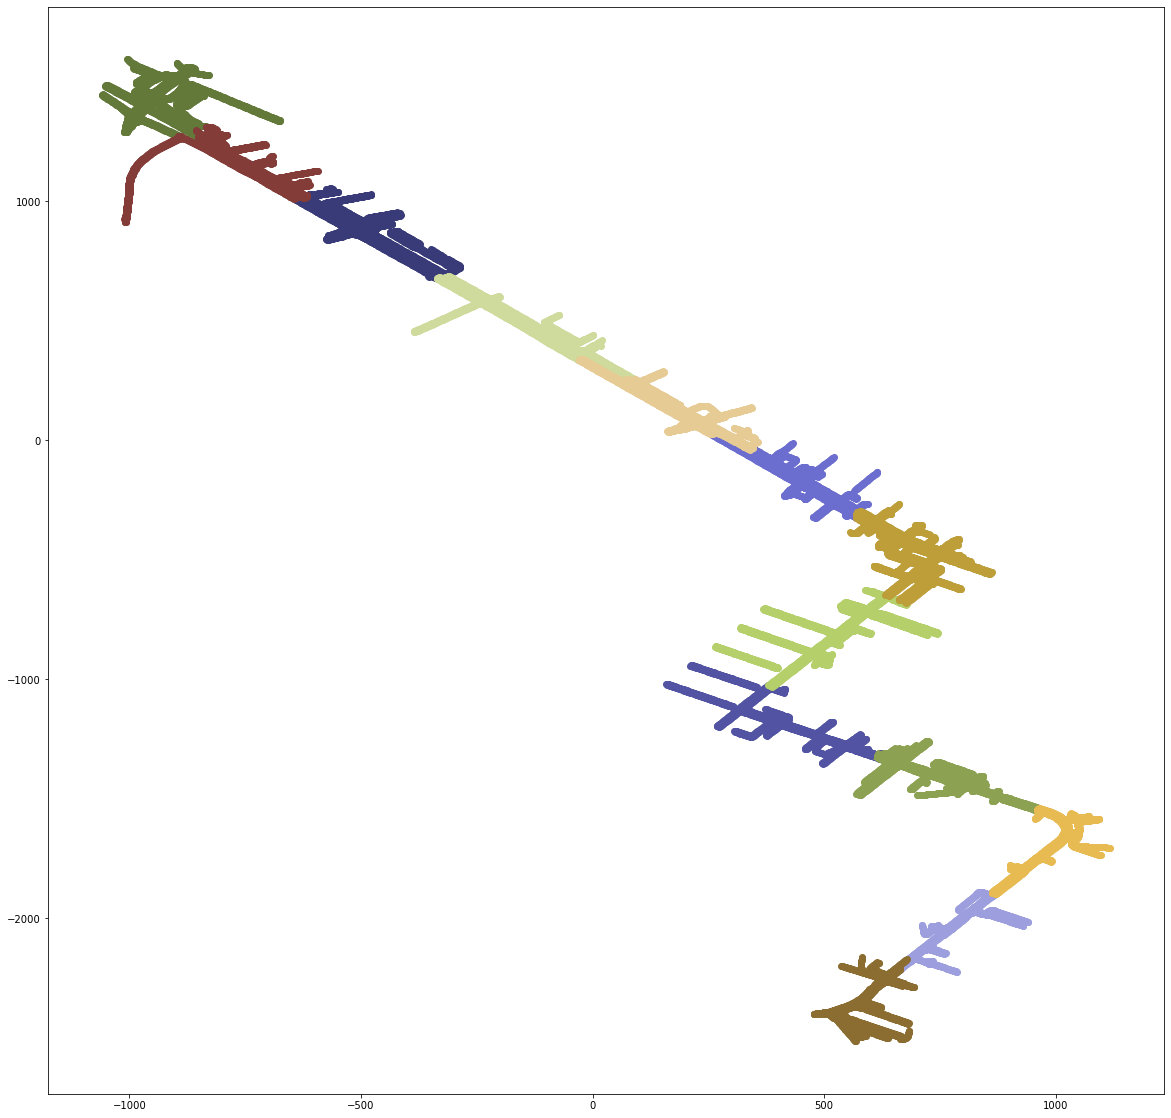

In [19]:
plt.figure(figsize=(20, 20))
for lane_id, cluster in lane_2_clusters.items():
    center_line = get_lane_center_line(lane_id)
    plt.scatter(center_line[:,0], center_line[:,1], color=cycled_colors[cluster%len(cycled_colors)])

In [20]:
n_base_segments = 13

segment_idx_x_min_rot = [float('inf') for _ in range(n_base_segments)]
segment_idx_y_min_rot = [float('inf') for _ in range(n_base_segments)]
segment_idx_x_max_rot = [-float('inf') for _ in range(n_base_segments)]
segment_idx_y_max_rot = [-float('inf') for _ in range(n_base_segments)]
# estimating segment boarders       
for lane_id, cluster in lane_2_clusters.items():
    segment_lane_center_rot = get_lane_center_line(lane_id).copy()
    for point_i in range(len(segment_lane_center_rot)):
        segment_lane_center_rot[point_i] = rotate_point(*segment_lane_center_rot[point_i])

    segment_idx_x_min_rot[cluster] = min(segment_idx_x_min_rot[cluster], segment_lane_center_rot[:, 0].min())
    segment_idx_y_min_rot[cluster] = min(segment_idx_y_min_rot[cluster], segment_lane_center_rot[:, 1].min())
    segment_idx_x_max_rot[cluster] = max(segment_idx_x_max_rot[cluster], segment_lane_center_rot[:, 0].max())
    segment_idx_y_max_rot[cluster] = max(segment_idx_y_max_rot[cluster], segment_lane_center_rot[:, 1].max())   
  

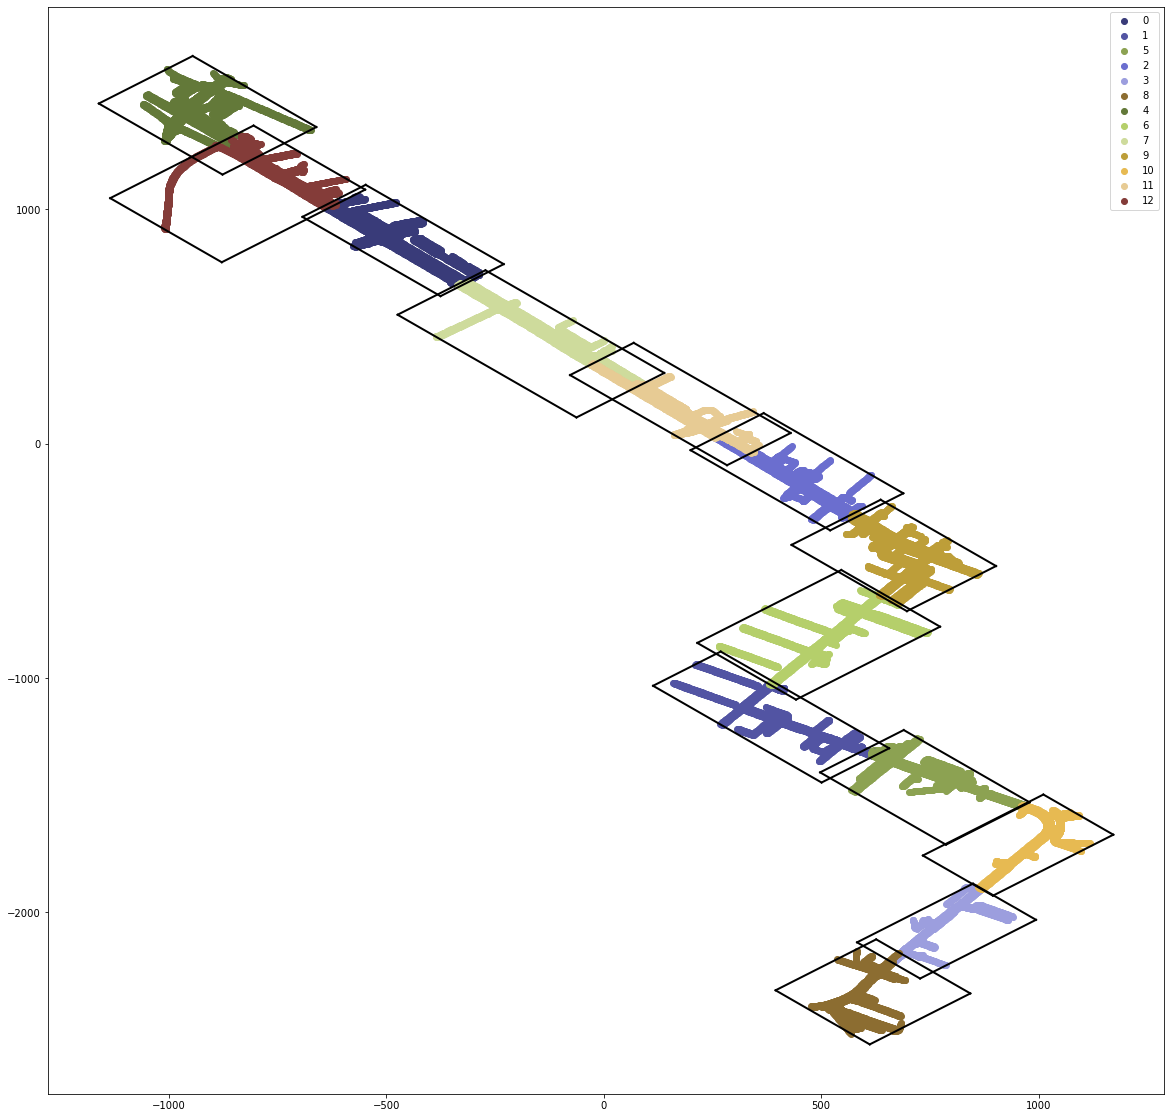

In [21]:
plt.figure(figsize=(20, 20))
clusters_added_to_legend = set()
for lane_id, cluster in lane_2_clusters.items():
    center_line = get_lane_center_line(lane_id)
    plt.scatter(center_line[:,0], center_line[:,1], color=cycled_colors[cluster%len(cycled_colors)], label=f'{cluster}' if cluster not in clusters_added_to_legend else None)
    clusters_added_to_legend.add(cluster)

for segment_idx in range(n_base_segments):
    corner1 = rotate_point(segment_idx_x_min_rot[segment_idx], segment_idx_y_min_rot[segment_idx], back=True)
    corner2 = rotate_point(segment_idx_x_min_rot[segment_idx], segment_idx_y_max_rot[segment_idx], back=True)
    corner3 = rotate_point(segment_idx_x_max_rot[segment_idx], segment_idx_y_max_rot[segment_idx], back=True)
    corner4 = rotate_point(segment_idx_x_max_rot[segment_idx], segment_idx_y_min_rot[segment_idx], back=True)
    plt.plot([corner1[0], corner2[0]], [corner1[1], corner2[1]], color='black', linewidth=2)
    plt.plot([corner2[0], corner3[0]], [corner2[1], corner3[1]], color='black', linewidth=2)
    plt.plot([corner3[0], corner4[0]], [corner3[1], corner4[1]], color='black', linewidth=2)
    plt.plot([corner4[0], corner1[0]], [corner4[1], corner1[1]], color='black', linewidth=2)
plt.legend()

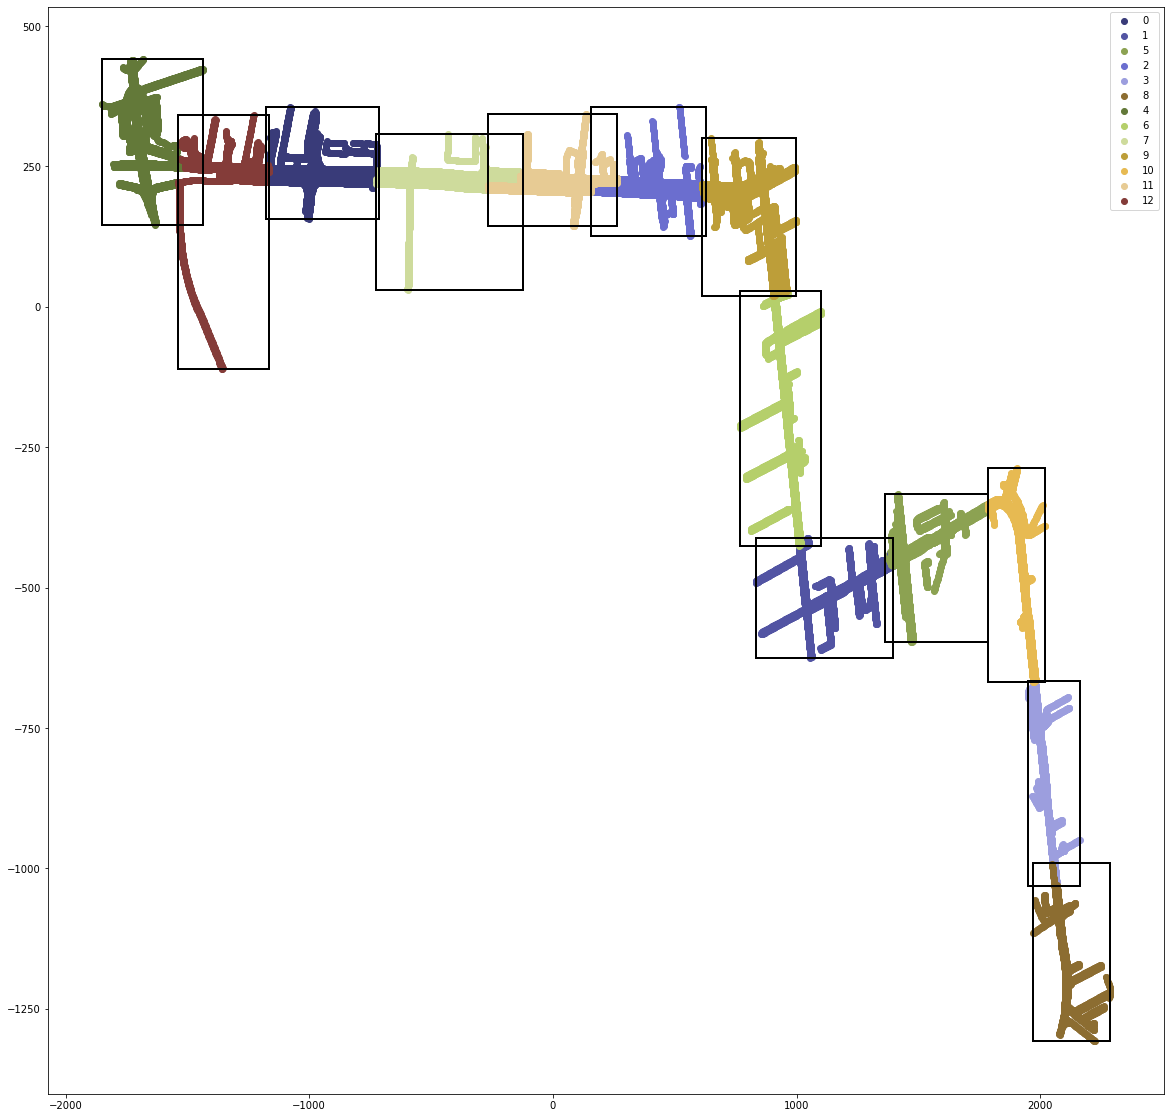

In [22]:
plt.figure(figsize=(20, 20))
clusters_added_to_legend = set()
for lane_id, cluster in lane_2_clusters.items():
    center_line = get_lane_center_line(lane_id).copy()
    for i in range(len(center_line)):
        center_line[i] = rotate_point(*center_line[i])     
    plt.scatter(center_line[:,0], center_line[:,1], color=cycled_colors[cluster%len(cycled_colors)], label=f'{cluster}' if cluster not in clusters_added_to_legend else None)
    clusters_added_to_legend.add(cluster)
    
segment_x_coords = []
segment_y_coords = []
TYPE_MAX = 0
TYPE_MIN = -1
for segment_idx in range(n_base_segments):
    corner1 = segment_idx_x_min_rot[segment_idx], segment_idx_y_min_rot[segment_idx]
    corner2 = segment_idx_x_min_rot[segment_idx], segment_idx_y_max_rot[segment_idx]
    corner3 = segment_idx_x_max_rot[segment_idx], segment_idx_y_max_rot[segment_idx]
    corner4 = segment_idx_x_max_rot[segment_idx], segment_idx_y_min_rot[segment_idx]
    plt.plot([corner1[0], corner2[0]], [corner1[1], corner2[1]], color='black', linewidth=2)
    plt.plot([corner2[0], corner3[0]], [corner2[1], corner3[1]], color='black', linewidth=2)
    plt.plot([corner3[0], corner4[0]], [corner3[1], corner4[1]], color='black', linewidth=2)
    plt.plot([corner4[0], corner1[0]], [corner4[1], corner1[1]], color='black', linewidth=2)
    
    segment_x_coords.append((segment_idx_x_min_rot[segment_idx], segment_idx, TYPE_MIN))
    segment_x_coords.append((segment_idx_x_max_rot[segment_idx], segment_idx, TYPE_MAX))
    segment_y_coords.append((segment_idx_y_min_rot[segment_idx], segment_idx, TYPE_MIN))
    segment_y_coords.append((segment_idx_y_max_rot[segment_idx], segment_idx, TYPE_MAX))
    
    
plt.legend()

In [34]:
segment_x_coords = sorted(segment_x_coords, key=lambda x: x[0])
segment_y_coords = sorted(segment_y_coords, key=lambda x: x[0])

def map_intervals_to_coordinate_segments(segment_coords):
    active_segments = set()
    interval_2_segments = []
    for coord_interval, (coord, segment_idx, point_type) in enumerate(segment_coords):
        if point_type == TYPE_MIN:
            active_segments.add(segment_idx)
        elif point_type == TYPE_MAX:
            active_segments.remove(segment_idx)
        else:
            raise NotImplementedError('Unknown point type')
        interval_2_segments.append(active_segments.copy())
    return interval_2_segments

interval_2_segments_x = map_intervals_to_coordinate_segments(segment_x_coords)   
interval_2_segments_y = map_intervals_to_coordinate_segments(segment_y_coords) 
segment_x_coords_only = [x[0] for x in segment_x_coords]
segment_y_coords_only = [x[0] for x in segment_y_coords]

def match_point_2_map_segment(x_coord, y_coord):
    x_coord, y_coord = rotate_point(x_coord, y_coord)
    x_interval = bisect.bisect_right(segment_x_coords_only, x_coord) - 1
    y_interval = bisect.bisect_right(segment_y_coords_only, y_coord) - 1
    return sorted(interval_2_segments_x[x_interval].intersection(interval_2_segments_y[y_interval]),
                  key=lambda segment_i: len(map_segment_2_lanes[segment_i]))

In [24]:
map_segment_2_lanes = [set() for _ in range(n_base_segments)]

for lane_id, map_segment_idx in lane_2_clusters.items():
    map_segment_2_lanes[map_segment_idx].add(lane_id)

In [25]:
# for matches on boarders as well to then have several seq2seq models for lane-seq prediction -> add at least 50 points of consecutive lanes for each segment
min_lane_points_dist = 50

for map_segment_idx in range(n_base_segments):
    lanes_to_add = set()
    for lane_id in map_segment_2_lanes[map_segment_idx]:
        queue = deque()
        closed_set = set()
        queue.append((lane_id, 0))
        while len(queue):
            next_lane_id, dist_from_init = queue.popleft()
            closed_set.add(next_lane_id)
            if next_lane_id not in map_segment_2_lanes[map_segment_idx] and next_lane_id not in lanes_to_add:
                lanes_to_add.add(next_lane_id)
            next_dist_from_init = dist_from_init + get_lane_len(next_lane_id)
            if next_dist_from_init < min_lane_points_dist:
                for next_lane_neigh in get_lane_neighbours_all(next_lane_id):
                    if next_lane_neigh not in closed_set:
                        queue.append((next_lane_neigh, next_dist_from_init))
    print(f'segment {map_segment_idx}, initially n_lanes: {len(map_segment_2_lanes[map_segment_idx])}, len(lanes_to_add): {len(lanes_to_add)}')
    map_segment_2_lanes[map_segment_idx].update(lanes_to_add)

segment 0, initially n_lanes: 217, len(lanes_to_add): 139
segment 1, initially n_lanes: 203, len(lanes_to_add): 136
segment 2, initially n_lanes: 254, len(lanes_to_add): 168
segment 3, initially n_lanes: 115, len(lanes_to_add): 187
segment 4, initially n_lanes: 213, len(lanes_to_add): 102
segment 5, initially n_lanes: 197, len(lanes_to_add): 270
segment 6, initially n_lanes: 200, len(lanes_to_add): 109
segment 7, initially n_lanes: 97, len(lanes_to_add): 40
segment 8, initially n_lanes: 171, len(lanes_to_add): 155
segment 9, initially n_lanes: 391, len(lanes_to_add): 216
segment 10, initially n_lanes: 156, len(lanes_to_add): 119
segment 11, initially n_lanes: 191, len(lanes_to_add): 81
segment 12, initially n_lanes: 162, len(lanes_to_add): 185


In [26]:
list(map(len, map_segment_2_lanes))

[356, 339, 422, 302, 315, 467, 309, 137, 326, 607, 275, 272, 347]

In [28]:
for lane_id in lane_id_2_idx.keys():
    lane_center_line = get_lane_center_line(lane_id)
    for coord in lane_center_line:
        map_segment_indices = match_point_2_map_segment(*coord)
        for map_segment_idx in map_segment_indices:
            if lane_id not in map_segment_2_lanes[map_segment_idx]:
                map_segment_2_lanes[map_segment_idx].add(lane_id)

In [29]:
list(map(len, map_segment_2_lanes))

[395, 396, 589, 402, 413, 543, 443, 168, 489, 652, 362, 324, 386]

In [31]:
sum(map(len, map_segment_2_lanes))

5562

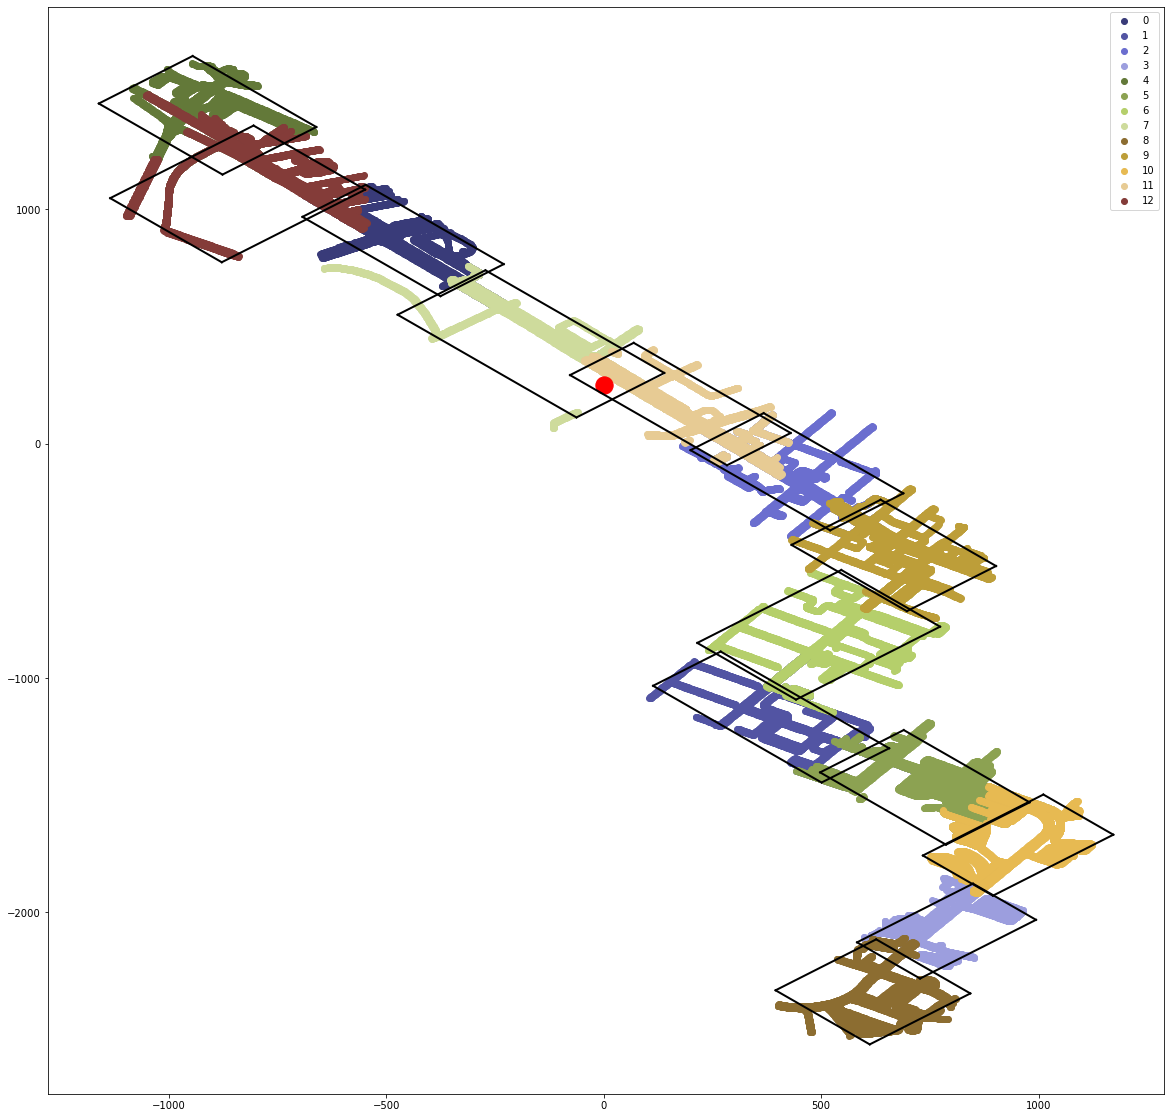

In [37]:
plt.figure(figsize=(20, 20))


for segment_idx in range(n_base_segments):
    clusters_added_to_legend = set()
    for lane_id in map_segment_2_lanes[segment_idx]:
        center_line = get_lane_center_line(lane_id)
        plt.scatter(center_line[:,0], center_line[:,1], color=cycled_colors[segment_idx%len(cycled_colors)], label=f'{segment_idx}' if segment_idx not in clusters_added_to_legend else None)
        clusters_added_to_legend.add(segment_idx)
    
    corner1 = rotate_point(segment_idx_x_min_rot[segment_idx], segment_idx_y_min_rot[segment_idx], back=True)
    corner2 = rotate_point(segment_idx_x_min_rot[segment_idx], segment_idx_y_max_rot[segment_idx], back=True)
    corner3 = rotate_point(segment_idx_x_max_rot[segment_idx], segment_idx_y_max_rot[segment_idx], back=True)
    corner4 = rotate_point(segment_idx_x_max_rot[segment_idx], segment_idx_y_min_rot[segment_idx], back=True)
    plt.plot([corner1[0], corner2[0]], [corner1[1], corner2[1]], color='black', linewidth=2)
    plt.plot([corner2[0], corner3[0]], [corner2[1], corner3[1]], color='black', linewidth=2)
    plt.plot([corner3[0], corner4[0]], [corner3[1], corner4[1]], color='black', linewidth=2)
    plt.plot([corner4[0], corner1[0]], [corner4[1], corner1[1]], color='black', linewidth=2)
plt.scatter(0,250, c='r', s=300)
plt.legend()